In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
import xgboost as xgb

In [4]:
import pandas as pd
import numpy as np
import os, psutil
import copy
import matplotlib.pyplot as plt
from ast import literal_eval
from datetime import datetime, timedelta

import pickle
import awswrangler as wr
import boto3
import gc
import math
import pyarrow.parquet as pq
pd.set_option('display.max_columns', None)

from tqdm import tqdm

tqdm.pandas()

# Results with OUD 6 months outcome

In [5]:
df = pd.read_csv('cohort_12-04_selected.csv')
pd.set_option('display.max_columns', None)

/home/ubuntu/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (12,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
columns = set(df.columns) - {"MA_NUM", "HCPCS_CD", "CLAIM_FROM_DT", "ICD9_CD", "ICD9_DT", 
                              "DISCHARG_DT", "POLICY_START_DT", "POLICY_END_DT", "DOB_DT",
                              "LNGCD_RF", "AIDCT_RF", "Source", 'Start_dt', 'End_dt', 'Overdose_Death', "Race", "Outcome_Abuse_3months", "Outcome_Abuse_3months",
                              "Outcome_Abuse_6months", "Outcome_Abuse_12months", "Outcome_Overdose_3months",
                              "Outcome_Overdose_6months", "Outcome_Overdose_12months", "Outcome_Overdose_12months",
                              "Outcome_3months", "Outcome_12months", "ZIP", "ZCTA5", "FIPS", "Main_Provider", 'Continuously_Enrolled_12months'}

columns = [x for x in df.columns if x in columns]

df = df[columns]

columns = [x for x in columns if x!='State']
df =df[columns]

In [7]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}

for f in ['GENCD_RF', 'Surgery_type']:
    le = LabelEncoder()
    le.fit(df[f])
    label_encoders[f] = le.classes_
    df[f+'_enc'] = le.transform(df[f])
    
df.drop(columns = ['GENCD_RF', 'Surgery_type', 'SURG_DT'], inplace = True)

In [8]:
dummies = pd.get_dummies(df['Surgery_type_enc'], prefix='Surgery')
df[dummies.columns] = dummies

In [9]:
new_columns = [x for x in df.columns if (x != 'Surgery_type_enc')]
RF_columns = new_columns
LR_columns = RF_columns

In [10]:
df_train, df_test = train_test_split(df[new_columns], test_size = 0.1, stratify = df['Outcome_6months'], random_state = 1)

X_train, y_train = df_train.drop(columns = ['Outcome_6months']), df_train['Outcome_6months']
X_test, y_test = df_test.drop(columns = ['Outcome_6months']), df_test['Outcome_6months']

X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_test.median())

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
def get_metrics(y_test, y_pred, thresh = 0.5):
    auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred >= thresh)
    p = precision_score(y_test, y_pred >= thresh)
    r = recall_score(y_test, y_pred >= thresh)
    return auc, f1, p, r
    
def test_split(model, X_test, y_test, random_state = 1, n_splits = 5):
    """Evaluation process: split the test set in 5 splits, evaluate the model on each split and 
       return the average/std of each metric"""
    
    shuffled = np.concatenate([X_test, y_test.values.reshape(-1,1)], axis = 1)
    splits = np.array_split(shuffled, n_splits)
    metrics = np.zeros((n_splits, 4))
    
    for i,x in enumerate(splits):
        
        y_pred = model.predict(x[:,:-1])
        try:
            y_pred_split = model.predict_proba(x[:,:-1])[:,1]
        except:
            y_pred_split = model.predict_proba(x[:,:-1])
        y_test_split = x[:,-1]
        try:
            metrics[i,:] = get_metrics(y_test_split,y_pred_split, model.thresh)
        except:
            metrics[i,:] = get_metrics(y_test_split,y_pred_split)
    
    res = pd.DataFrame(np.array([metrics.mean(axis = 0), metrics.std(axis = 0)]).T, columns = ['Mean', 'Std'], index = ['AUC', 'F1', 'Precision', 'Recall'])
    return res   

In [12]:
over = RandomOverSampler(sampling_strategy=0.3, random_state = 1)
under = RandomUnderSampler(sampling_strategy=0.7, random_state = 1)

X_train_res, y_train_res = over.fit_resample(X_train, y_train)
X_train_res, y_train_res = under.fit_resample(X_train_res, y_train_res)

In [13]:
class new_model:
    """ Class used to easily use thresholding for model prediction"""
    def __init__(self, mod, thresh = None):
        self.model = mod
        if thresh:
            self.thresh = thresh    
        return
    
    def predict(self, X_test):
        try:
            proba_predicted = self.model.predict_proba(X_test)[:,1]
        except:
            proba_predicted = self.model.predict_proba(X_test)
        return proba_predicted >= self.thresh
    
    def predict_proba(self, X_test):
        return self.model.predict_proba(X_test)

## Logistic regression

In [206]:
logreg = LogisticRegression()
logreg.fit(X_train_res, y_train_res)
test_split(logreg, X_test, y_test)

,Mean,Std
AUC,0.868898,0.012955
F1,0.547330,0.024163
Precision,0.462707,0.020060
Recall,0.670552,0.037391


## Ridge

In [12]:
ridge = LogisticRegression(penalty = 'l2', C = 0.001)
ridge.fit(X_train_res, y_train_res)
test_split(ridge, X_test, y_test)

,Mean,Std
AUC,0.869543,0.013518
F1,0.547227,0.020790
Precision,0.463515,0.017655
Recall,0.668945,0.036990


## Lasso

In [13]:
lasso = LogisticRegression(penalty = 'l1', solver = 'saga', C = 0.01)
lasso.fit(X_train_res, y_train_res)
test_split(lasso, X_test, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


,Mean,Std
AUC,0.870808,0.013677
F1,0.549252,0.024736
Precision,0.469909,0.021832
Recall,0.661885,0.038745


## Elastic net

In [15]:
elnet = LogisticRegression(penalty = 'elasticnet', solver = 'saga', C = 0.01, l1_ratio = 0.6)
elnet.fit(X_train_res, y_train_res)
test_split(elnet, X_test, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


,Mean,Std
AUC,0.870647,0.013625
F1,0.548726,0.025741
Precision,0.468218,0.021820
Recall,0.663745,0.041232


## Random forest

In [93]:
rf = RandomForestClassifier(max_depth = 20, n_estimators = 200, random_state = 1)
rf.fit(X_train_res, y_train_res)
test_split(rf, X_test, y_test)

,Mean,Std
AUC,0.876722,0.014380
F1,0.568177,0.013201
Precision,0.484533,0.016872
Recall,0.686724,0.018995


## XGBoost

In [20]:
import xgboost as xgb
xg = xgb.XGBClassifier(random_state = 1, eta = 0.1, reg_lambda = 1)
xg.fit(X_train, y_train)
test_split(new_model(xg, 0.15), X_test, y_test)

/home/ubuntu/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:09:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ubuntu/.local/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")
/home/ubuntu/.local/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")
/home/ubuntu/.local/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")
/home/ubuntu/.local/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")
/home/ubuntu/.local/lib/python3.6/site-packages/xgboost/data.py:

,Mean,Std
AUC,0.877257,0.011138
F1,0.554406,0.016690
Precision,0.469593,0.011026
Recall,0.677662,0.036845


## Deep NN

In [101]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,normalization,BatchNormalization,LSTM,GRU
from keras import backend as K
from keras.optimizers import Adam

In [104]:
dnn = Sequential()
dnn.add(Dense(128, activation='relu',input_shape=(X_train_res.shape[1],)))
dnn.add(Dropout(0.4))
dnn.add(Dense(128, activation='relu',input_shape=(X_train_res.shape[1],)))
dnn.add(Dropout(0.4))
dnn.add(Dense(128, activation='relu',input_shape=(X_train_res.shape[1],)))
dnn.add(Dropout(0.4))
dnn.add(Dense(128, activation='relu',input_shape=(X_train_res.shape[1],)))
dnn.add(Dropout(0.4))
dnn.add(Dense(32, activation='relu'))
dnn.add(Dropout(0.4))
dnn.add(Dense(8, activation='relu'))
dnn.add(Dense(1,activation='sigmoid'))

opt = Adam(learning_rate=0.0001)
dnn.compile(loss='binary_crossentropy',optimizer=opt,metrics=['AUC'])
history = dnn.fit(X_train_res,y_train_res,epochs=10, validation_data = (X_test, y_test))

Epoch 1/10
1773/1773 [==============================] - 5s 2ms/step - loss: 0.7266 - auc: 0.5296 - val_loss: 0.4912 - val_auc: 0.8259
Epoch 2/10
1773/1773 [==============================] - 4s 2ms/step - loss: 0.5640 - auc: 0.7769 - val_loss: 0.4090 - val_auc: 0.8605
Epoch 3/10
1773/1773 [==============================] - 4s 2ms/step - loss: 0.5040 - auc: 0.8296 - val_loss: 0.3926 - val_auc: 0.8673
Epoch 4/10
1773/1773 [==============================] - 4s 2ms/step - loss: 0.4712 - auc: 0.8526 - val_loss: 0.3873 - val_auc: 0.8696
Epoch 5/10
1773/1773 [==============================] - 4s 2ms/step - loss: 0.4609 - auc: 0.8584 - val_loss: 0.3781 - val_auc: 0.8701
Epoch 6/10
1773/1773 [==============================] - 4s 2ms/step - loss: 0.4495 - auc: 0.8660 - val_loss: 0.3733 - val_auc: 0.8703
Epoch 7/10
1773/1773 [==============================] - 4s 2ms/step - loss: 0.4459 - auc: 0.8689 - val_loss: 0.3810 - val_auc: 0.8707
Epoch 8/10
1773/1773 [==============================] - 4s 2ms

In [127]:
test_split(dnn, X_test, y_test)

/home/ubuntu/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/home/ubuntu/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/home/ubuntu/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/home/ubuntu/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is depr

,Mean,Std
AUC,0.870938,0.012669
F1,0.550893,0.021576
Precision,0.474716,0.017222
Recall,0.656762,0.034112


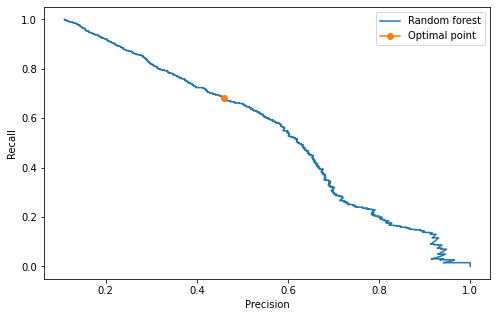

In [216]:
plt.figure(figsize = (8,5))
prec, rec, thr = precision_recall_curve(y_test, y_pred_proba[:,1])
opt_point = (prec[(prec >= 0.475) & (rec >= 0.685)][0], rec[(prec >= 0.475) & (rec >= 0.685)][0])

plt.plot(prec, rec, label = 'Random forest')
plt.plot(opt_point[0], opt_point[1], marker = 'o', label = 'Optimal point')


plt.xlabel('Precision')
plt.ylabel('Recall')
plt.legend(loc = 'best')
plt.savefig('prec_recall.svg')
plt.show()

## Feature importances

### RF feature importance with multicollinearity

In [217]:
df = pd.read_csv('cohort_12-04.csv')

columns = set(df.columns) - {"MA_NUM", "HCPCS_CD", "CLAIM_FROM_DT", "ICD9_CD", "ICD9_DT", 
                              "DISCHARG_DT", "POLICY_START_DT", "POLICY_END_DT", "DOB_DT", 'Unemployment_rate_2018',
                                 'Median_Household_Income_2018',
                                 'Med_HH_Income_Percent_of_State_Total_2018',
                                 'PCTPOVALL_2018',
                                 'Percent_less_than_high_school_1418',
                                 'Percent_only_high_school_1418',
                                 'Percent_some_college_1418',
                                 'Percent_bachelors_or_higher_1418',
                              "LNGCD_RF", "AIDCT_RF", "Source", 'Start_dt', 'End_dt', 'Overdose_Death', "Race", "Outcome_Abuse_3months", "Outcome_Abuse_3months",
                              "Outcome_Abuse_6months", "Outcome_Abuse_12months", "Outcome_Overdose_3months",
                              "Outcome_Overdose_6months", "Outcome_Overdose_12months", "Outcome_Overdose_12months",
                              "Outcome_3months", "Outcome_12months", "ZIP", "ZCTA5", "FIPS", "Main_Provider", 'Continuously_Enrolled_12months'}

columns = [x for x in df.columns if x in columns]

df = df[columns]

columns = [x for x in columns if x!='State']
df =df[columns]

from sklearn.preprocessing import LabelEncoder

label_encoders = {}

for f in ['GENCD_RF', 'Surgery_type']:
    le = LabelEncoder()
    le.fit(df[f])
    label_encoders[f] = le.classes_
    df[f+'_enc'] = le.transform(df[f])
    
df.drop(columns = ['GENCD_RF', 'Surgery_type', 'SURG_DT'], inplace = True)

dummies = pd.get_dummies(df['Surgery_type_enc'], prefix='Surgery')
df[dummies.columns] = dummies

new_columns = [x for x in df.columns if (x != 'Surgery_type_enc')]
RF_columns = new_columns
LR_columns = RF_columns

df_train, df_test = train_test_split(df[new_columns], test_size = 0.1, stratify = df['Outcome_6months'], random_state = 1)

cols_to_drop = list(df_train.std()[(df_train.std() == 0)].index)
df_train = df_train.drop(columns = cols_to_drop)
df_test = df_test.drop(columns = cols_to_drop)

/home/ubuntu/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (12,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [218]:
X_train, y_train = df_train.drop(columns = ['Outcome_6months']), df_train['Outcome_6months']
X_test, y_test = df_test.drop(columns = ['Outcome_6months']), df_test['Outcome_6months']

X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_test.median())

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


over = RandomOverSampler(sampling_strategy=0.3, random_state = 1)
under = RandomUnderSampler(sampling_strategy=0.7, random_state = 1)

X_train_res, y_train_res = over.fit_resample(X_train, y_train)
X_train_res, y_train_res = under.fit_resample(X_train_res, y_train_res)

In [219]:
ccsr_cat_dx = pd.read_excel('~/Desktop/Resources/DXCCSR-Reference-File-v2021-2.xlsx', sheet_name = 'CCSR_Categories', skiprows = 1, engine = 'openpyxl')
ccsr_cat_proc = pd.read_excel('~/Desktop/Resources/PRCCSR-Reference-File-v2021-1.xlsx', sheet_name = 'CCSR_Categories', skiprows = 1, engine = 'openpyxl').iloc[:-1,:]

ccsr_cat_dx = ccsr_cat_dx[['CCSR Category','CCSR Category Description']].set_index('CCSR Category').T.to_dict('list')
ccsr_cat_proc = ccsr_cat_proc[['CCSR Category','CCSR Category Description']].set_index('CCSR Category').T.to_dict('list')

In [220]:
def labelize_features(x):
    if x[:4]=='Diag':
        return ccsr_cat_dx[x[5:]][0]
    elif x[:4]=='Proc':
        return ccsr_cat_proc[x[5:]][0]
    elif x[:7]=='Surgery':
        return label_encoders['Surgery_type'][int(x[8:])]
    elif x == 'GENCD_RF_enc':
        return 'Gender'
    else:
        return x

In [223]:
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

corr = spearmanr(X_train).correlation
corr_linkage = hierarchy.ward(corr)
cluster_ids = hierarchy.fcluster(corr_linkage, 1.5, criterion='distance')
cols = df_train.drop(columns = ['Outcome_6months']).columns
cluster_dict = {cols[i]: cluster_ids[i] for i in range(len(cluster_ids))}
new_dict = {}
for x, id_ in cluster_dict.items():
    if id_ in new_dict:
        new_dict[id_].add(x)
    else:
        new_dict[id_] = {x}
cluster_dict = new_dict

In [224]:
selected_features = []
for i, s in cluster_dict.items():
    selected_features.append(sorted([i for i,x in enumerate(cols) if x in s], key = lambda i: len(cols[i]))[0])  

print('Selected {}/{} features'.format(len(selected_features), df_train.shape[1]))

Selected 307/896 features


In [225]:
X_train_small = X_train[:,selected_features]
X_test_small = X_test[:,selected_features]

In [229]:
rf_small = RandomForestClassifier(max_depth = 20, n_estimators = 200, random_state = 1)
rf_small.fit(X_train_small, y_train)

RandomForestClassifier(max_depth=20, n_estimators=200, random_state=1)

### Shap feature importance

In [249]:
import shap
shap.initjs()

In [251]:
explainer = shap.TreeExplainer(rf_small)

In [252]:
shap_values = explainer.shap_values(X_train_small)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [254]:
final_label_mapping = {'MME': 'Cumulative daily MME',
                       'MME_initial': 'Initial prescription daily MME',
                       'opioid_naive': 'Opioid naive',
                       'Urban_influence_code_2013': 'Urban influence code',
                       'Hydrocodone_is_initial': 'Initial hydrocodone prescription',
                       'Hydrocodone_MME': 'MME of hydrocodone prescriptions',
                       'cholecystectomy': 'Cholecystectomy',
                       }

final_labels = [labelize_features(cols[s]) for s in selected_features]
for i,x in enumerate(final_labels):
    if x in final_label_mapping:
        final_labels[i] = final_label_mapping[x]

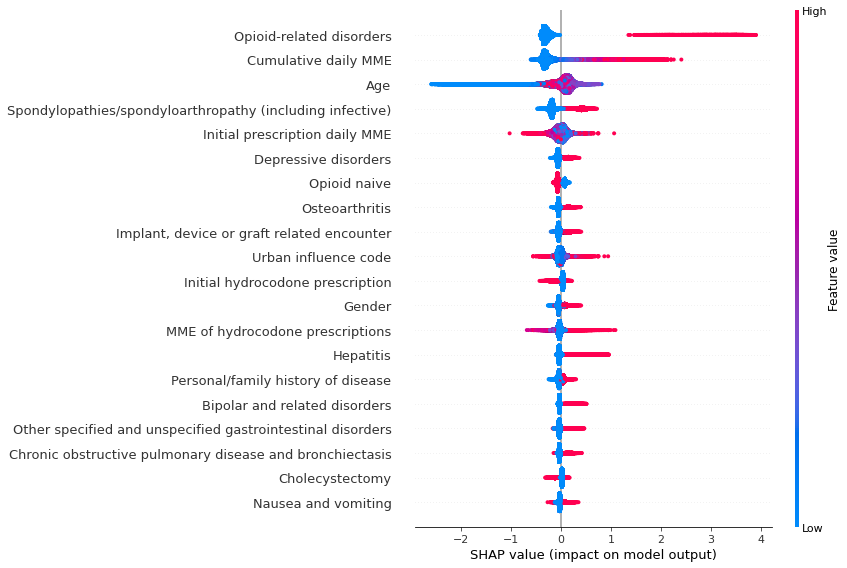

<Figure size 432x288 with 0 Axes>

In [256]:
nb_feat = 20
shap.summary_plot(shap_values, features= X_train_small, feature_names=final_labels, max_display=nb_feat)
plt.savefig('shap_importance.svg')